In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import sys
import json
from IPython.display import display
sns.reset_orig()
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from catalogue import load_catalogue

In [2]:
# Set the output directories here
outdirs_1 = [
    ('outdir_b_all_cauchy', 'log_evidence'),
    # ('outdir_b_all_gaussian', 'log_evidence'),
    ('outdir_b_all_equad50', 'log_evidence'),
    # ('outdir_b_all_eflq50', 'log_evidence'),
    ('outdir_a_all', 'aic'),
]

outdirs_2 = [
    ('outdir_b_img_cauchy', 'log_evidence'),
    # ('outdir_b_img_gaussian', 'log_evidence'),
    ('outdir_b_img_equad50', 'log_evidence'),
    # ('outdir_b_img_eflq50', 'log_evidence'),
    ('outdir_a_img', 'aic'),
]

In [3]:
def results_from_outdirs(outdirs, msp=False, ten_points=False):
    results, param_ests = [], []
    for outdir, var in outdirs:
        with open(f'../output/results_param_estimates_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
            param_est = json.load(f)
        with open(f'../output/results_{var}_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
            result = pd.DataFrame(json.load(f)).T
        with open(f'../output/results_good_fit_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
            good_fit_results = pd.DataFrame(json.load(f)).T  # table of true/false
            # transform good_fit_results to array of bools
            good_fit_results = good_fit_results.applymap(lambda x: x == 'True')
        
        # set result to NaN if the fit is not good
        result = result.where(good_fit_results)
        
        # best_fitting column
        result['best_fitting'] = result.idxmax(axis=1) if var == 'log_evidence' else result.idxmin(axis=1)
        
        # if all columns are NaN, set best_fitting to '(Unclassified)'
        result['best_fitting'] = result['best_fitting'].fillna('(Unclassified)')
            
        print(f'{outdir}:')
        catalogue = load_catalogue(outdirs[0][0])
        print(f' - Number of pulsars in the catalogue: {len(catalogue)}')
        str1, str2 = '', ''
        for n in range(4, 7):
            str1 += f', {n}'
            str2 += f', {len(catalogue.at_least_n_points(n))}'
        str1 = str1[2:]
        str2 = str2[2:]
        print(f' - Number of pulsars with at least {str1} measurements: {str2}')
        print(f' - Number of pulsars reaching fitting requirements: {len(result)}')
        if msp or ten_points:
            subset = catalogue.MSPs if msp else catalogue.at_least_n_points(10)
            subset = [jname for jname in subset if jname in result.index]
            result = result.loc[subset]
        results.append(result)
        param_ests.append(param_est)
    return results, param_ests

In [4]:
model_names = ['simple_power_law', 'broken_power_law', 'log_parabolic_spectrum', 'high_frequency_cut_off_power_law', 'low_frequency_turn_over_power_law', 'double_turn_over_spectrum', '(Unclassified)']
model_names_c = ['simple power law', 'broken power law', 'log-parabolic spectrum', 'high-frequency cut-off power law', 'low-frequency turn-over power law', 'double turn-over spectrum', '(Unclassified)']
model_names_b = ['simple\npower law', 'broken\npower law', 'log-parabolic\nspectrum', 'high-frequency\ncut-off power law', 'low-frequency\nturn-over power law', 'double\nturn-over spectrum', '(Unclassified)']
model_name_cap = lambda x: np.array([model_names_c[model_names.index(m)] for m in x])
model_name_br = lambda x: np.array([model_names_c[model_names.index(m)] for m in x])
def bar_chart(outdirs, save_path=None, msp=False, ten_points=False):
    results, _ = results_from_outdirs(outdirs, msp, ten_points)
    rx, ry = [], []
    r_total = []
    for r in results:
        rx_i = r['best_fitting'].value_counts().index.to_numpy()
        ry_i = r['best_fitting'].value_counts().to_numpy()
        rx.append(rx_i)
        ry.append(ry_i)
        r_total.append(len(r))
    
    # get the true total
    total = max(r_total)
    
    # move unclassified to the end
    if '(Unclassified)' in rx[0]:
        idx = np.where(rx[0] == '(Unclassified)')[0][0]
        rx[0] = np.concatenate([rx[0][:idx], rx[0][idx+1:], [rx[0][idx]]])
        ry[0] = np.concatenate([ry[0][:idx], ry[0][idx+1:], [ry[0][idx]]])
    
    # sort by rx[0]
    N = len(rx)
    # add the missing model names to rx[0]
    rx_0_missing = [model for model in model_names if model not in rx[0]]
    rx[0] = np.concatenate([rx[0], rx_0_missing])
    ry[0] = np.concatenate([ry[0], np.zeros(len(rx_0_missing))])
    for i in range(1, N):
        # add the missing model names to rest of the rx
        for j, model in enumerate(rx[0]):
            if model not in rx[i]:
                rx[i] = np.insert(rx[i], j, model)
                ry[i] = np.insert(ry[i], j, 0)
                
        rx[i], ry[i] = zip(*sorted(zip(rx[i], ry[i]), key=lambda x: rx[0].tolist().index(x[0])))
        
    # recalculate Unclassified
    for i, (x, y, t) in enumerate(zip(rx, ry, r_total)):
        if x[-1] == '(Unclassified)' and t != total:
            ry[i] = np.append(list(y)[:-1], list(y)[-1] + total - t)
    
    df_dict = {
        'Model': model_name_cap(rx[0]).tolist(),
    }
    for i, (x, y) in enumerate(zip(rx, ry)):
        df_dict[outdirs[i][0]] = [f'{v:.0f} / {total} ({v/total*100:.1f}%)' for v in y]
    display(pd.DataFrame(df_dict))
    
    r_bf_dict = {}
    r_bf_gt5_dict = {}
    r_bf_total = {}
    for r, outdir_var in zip(results, outdirs):
        outdir, var = outdir_var
        if var == 'aic':
            continue
        r = r[r['best_fitting'] != '(Unclassified)']  # Remove unclassified pulsars
        r_bf = r.drop(columns='best_fitting').sub(r['simple_power_law'], axis=0).drop(columns='simple_power_law')
        r_bf_dict[outdir] = r_bf
        r_bf_gt5_dict[outdir] = (r_bf > 3).sum()
        r_bf_total[outdir] = len(r)
        
    # sort by the first method
    r_bf_gt5 = pd.DataFrame(r_bf_gt5_dict)
    
    r_bf_gt5.loc['(Any ln BF > 3)'] = [(r_bf > 3).any(axis=1).sum() for r_bf in r_bf_dict.values()]
    r_bf_gt5.loc['(All ln BF < -3)'] = [(r_bf < -3).all(axis=1).sum() for r_bf in r_bf_dict.values()]
    
    # change the values to {} / {} = {}% format
    for col in r_bf_gt5.columns:
        r_bf_gt5[col] = [f'{r_bf_gt5[col][i]:.0f} / {r_bf_total[col]} ({r_bf_gt5[col][i]/r_bf_total[col]*100:.1f}%)' for i in r_bf_gt5.index]
    display(r_bf_gt5)
    
    fig, ax = plt.subplots(figsize=(24, 4))
    
    bar_width = 1 / (N + 1)
    bar_positions = np.arange(len(rx[0]))
    
    colors = sns.color_palette('icefire', N)
    for i, (x, y) in enumerate(zip(rx, ry)):
        ax.bar(bar_positions + bar_width * (i - N / 2), y, bar_width, label=outdirs[i][0], color=colors[i])
        labels = [f'{v:.0f}\n{v/total*100:.1f}%' for v in y]
        for j, label in enumerate(labels):
            ax.text(j + bar_width * (i - N / 2), y[j] + 1, label, ha='center', va='bottom', fontsize=9)
    
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(model_name_br(rx[0]))
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

outdir_b_all_cauchy:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882
outdir_b_all_equad50:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 868
outdir_a_all:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882


,Model,outdir_b_all_cauchy,outdir_b_all_equad50,outdir_a_all
0,broken power law,299 / 882 (33.9%),248 / 882 (28.1%),292 / 882 (33.1%)
1,simple power law,257 / 882 (29.1%),307 / 882 (34.8%),234 / 882 (26.5%)
2,low-frequency turn-over power law,208 / 882 (23.6%),213 / 882 (24.1%),61 / 882 (6.9%)
3,double turn-over spectrum,56 / 882 (6.3%),34 / 882 (3.9%),28 / 882 (3.2%)
4,high-frequency cut-off power law,27 / 882 (3.1%),23 / 882 (2.6%),84 / 882 (9.5%)
5,log-parabolic spectrum,27 / 882 (3.1%),27 / 882 (3.1%),168 / 882 (19.0%)
6,(Unclassified),8 / 882 (0.9%),30 / 882 (3.4%),15 / 882 (1.7%)


,outdir_b_all_cauchy,outdir_b_all_equad50
broken_power_law,297 / 874 (34.0%),206 / 852 (24.2%)
double_turn_over_spectrum,211 / 874 (24.1%),143 / 852 (16.8%)
high_frequency_cut_off_power_law,142 / 874 (16.2%),86 / 852 (10.1%)
log_parabolic_spectrum,213 / 874 (24.4%),165 / 852 (19.4%)
low_frequency_turn_over_power_law,264 / 874 (30.2%),204 / 852 (23.9%)
(Any ln BF > 3),331 / 874 (37.9%),236 / 852 (27.7%)
(All ln BF < -3),0 / 874 (0.0%),0 / 852 (0.0%)


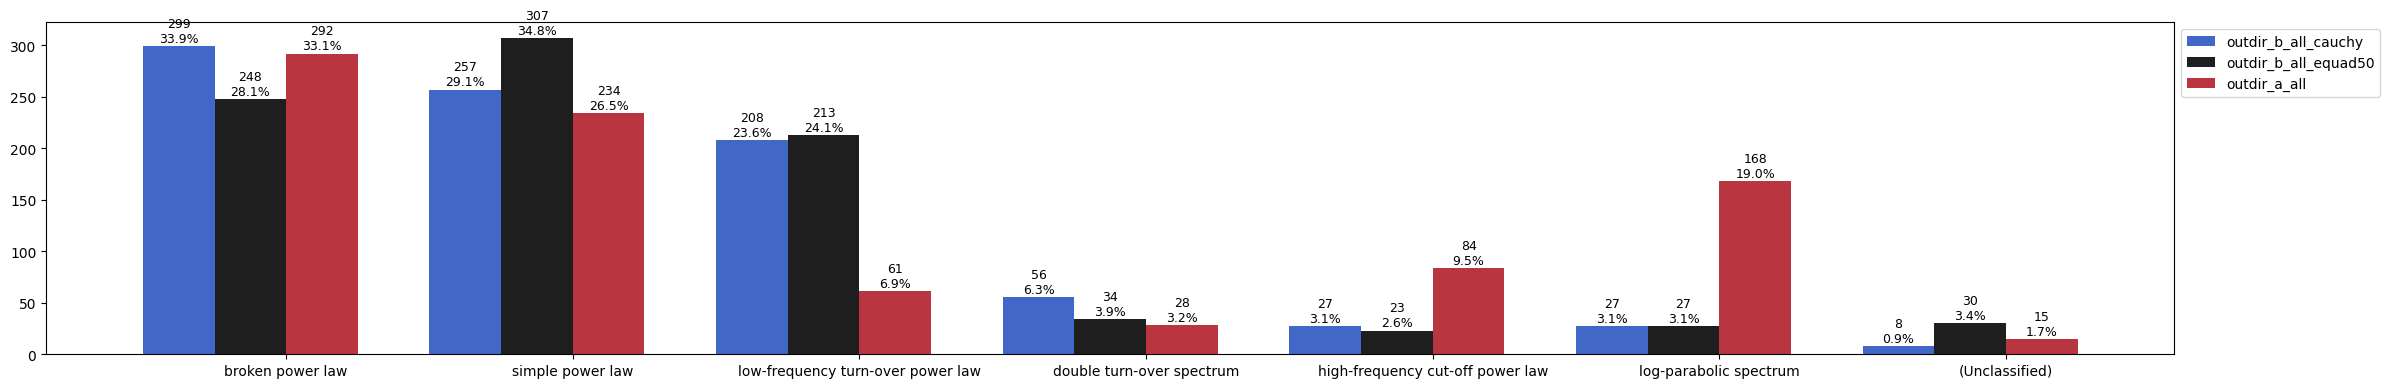

In [5]:
bar_chart(outdirs_1, 'bar_chart_1.png')

outdir_b_img_cauchy:
 - Number of pulsars in the catalogue: 425
 - Number of pulsars with at least 4, 5, 6 measurements: 36, 21, 14
 - Number of pulsars reaching fitting requirements: 36
outdir_b_img_equad50:
 - Number of pulsars in the catalogue: 425
 - Number of pulsars with at least 4, 5, 6 measurements: 36, 21, 14
 - Number of pulsars reaching fitting requirements: 36
outdir_a_img:
 - Number of pulsars in the catalogue: 425
 - Number of pulsars with at least 4, 5, 6 measurements: 36, 21, 14
 - Number of pulsars reaching fitting requirements: 36


,Model,outdir_b_img_cauchy,outdir_b_img_equad50,outdir_a_img
0,simple power law,12 / 36 (33.3%),15 / 36 (41.7%),18 / 36 (50.0%)
1,low-frequency turn-over power law,12 / 36 (33.3%),13 / 36 (36.1%),1 / 36 (2.8%)
2,broken power law,11 / 36 (30.6%),8 / 36 (22.2%),4 / 36 (11.1%)
3,double turn-over spectrum,1 / 36 (2.8%),0 / 36 (0.0%),0 / 36 (0.0%)
4,log-parabolic spectrum,0 / 36 (0.0%),0 / 36 (0.0%),9 / 36 (25.0%)
5,high-frequency cut-off power law,0 / 36 (0.0%),0 / 36 (0.0%),3 / 36 (8.3%)
6,(Unclassified),0 / 36 (0.0%),0 / 36 (0.0%),1 / 36 (2.8%)


,outdir_b_img_cauchy,outdir_b_img_equad50
broken_power_law,8 / 36 (22.2%),3 / 36 (8.3%)
double_turn_over_spectrum,4 / 36 (11.1%),2 / 36 (5.6%)
high_frequency_cut_off_power_law,1 / 36 (2.8%),1 / 36 (2.8%)
log_parabolic_spectrum,5 / 36 (13.9%),2 / 36 (5.6%)
low_frequency_turn_over_power_law,9 / 36 (25.0%),5 / 36 (13.9%)
(Any ln BF > 3),10 / 36 (27.8%),5 / 36 (13.9%)
(All ln BF < -3),0 / 36 (0.0%),0 / 36 (0.0%)


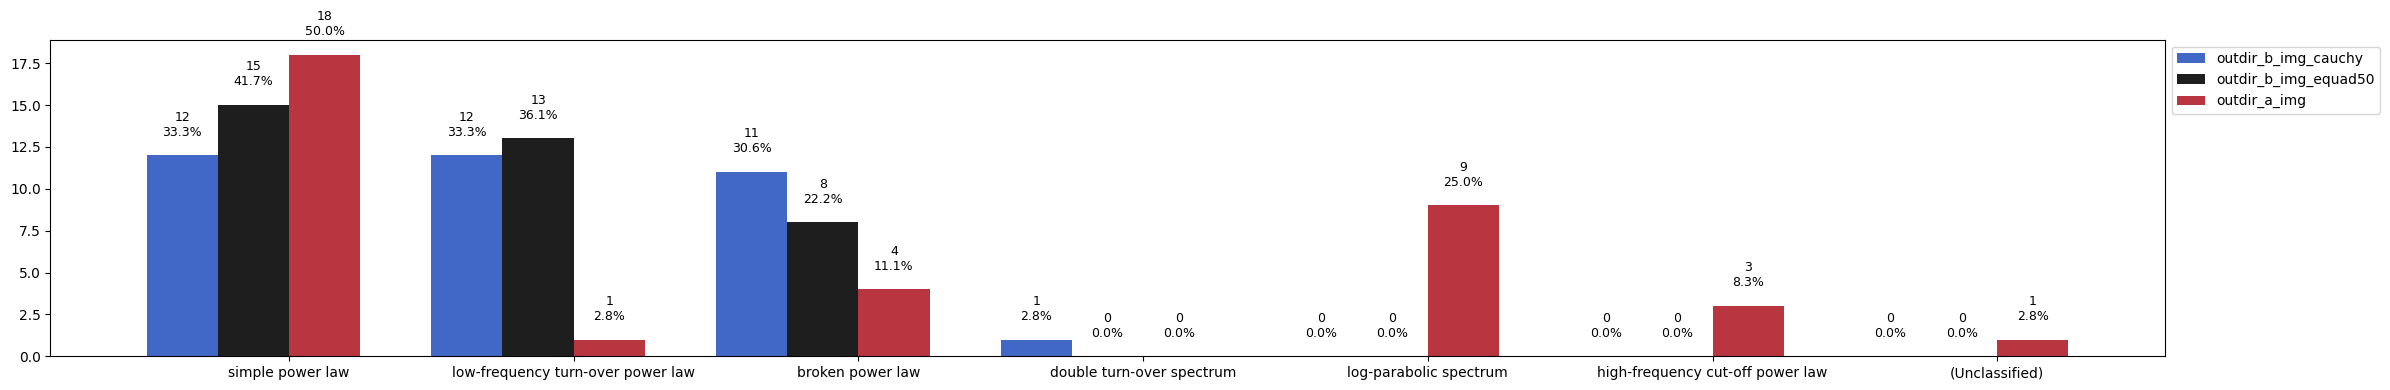

In [6]:
bar_chart(outdirs_2, 'bar_chart_2.png')

outdir_b_all_cauchy:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882
outdir_b_all_equad50:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 868
outdir_a_all:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882


,Model,outdir_b_all_cauchy,outdir_b_all_equad50,outdir_a_all
0,broken power law,29 / 85 (34.1%),32 / 85 (37.6%),25 / 85 (29.4%)
1,simple power law,29 / 85 (34.1%),23 / 85 (27.1%),25 / 85 (29.4%)
2,low-frequency turn-over power law,21 / 85 (24.7%),21 / 85 (24.7%),1 / 85 (1.2%)
3,high-frequency cut-off power law,4 / 85 (4.7%),4 / 85 (4.7%),6 / 85 (7.1%)
4,log-parabolic spectrum,2 / 85 (2.4%),1 / 85 (1.2%),25 / 85 (29.4%)
5,double turn-over spectrum,0 / 85 (0.0%),0 / 85 (0.0%),1 / 85 (1.2%)
6,(Unclassified),0 / 85 (0.0%),4 / 85 (4.7%),2 / 85 (2.4%)


,outdir_b_all_cauchy,outdir_b_all_equad50
broken_power_law,27 / 85 (31.8%),28 / 81 (34.6%)
double_turn_over_spectrum,14 / 85 (16.5%),12 / 81 (14.8%)
high_frequency_cut_off_power_law,15 / 85 (17.6%),15 / 81 (18.5%)
log_parabolic_spectrum,16 / 85 (18.8%),21 / 81 (25.9%)
low_frequency_turn_over_power_law,22 / 85 (25.9%),24 / 81 (29.6%)
(Any ln BF > 3),29 / 85 (34.1%),31 / 81 (38.3%)
(All ln BF < -3),0 / 85 (0.0%),0 / 81 (0.0%)


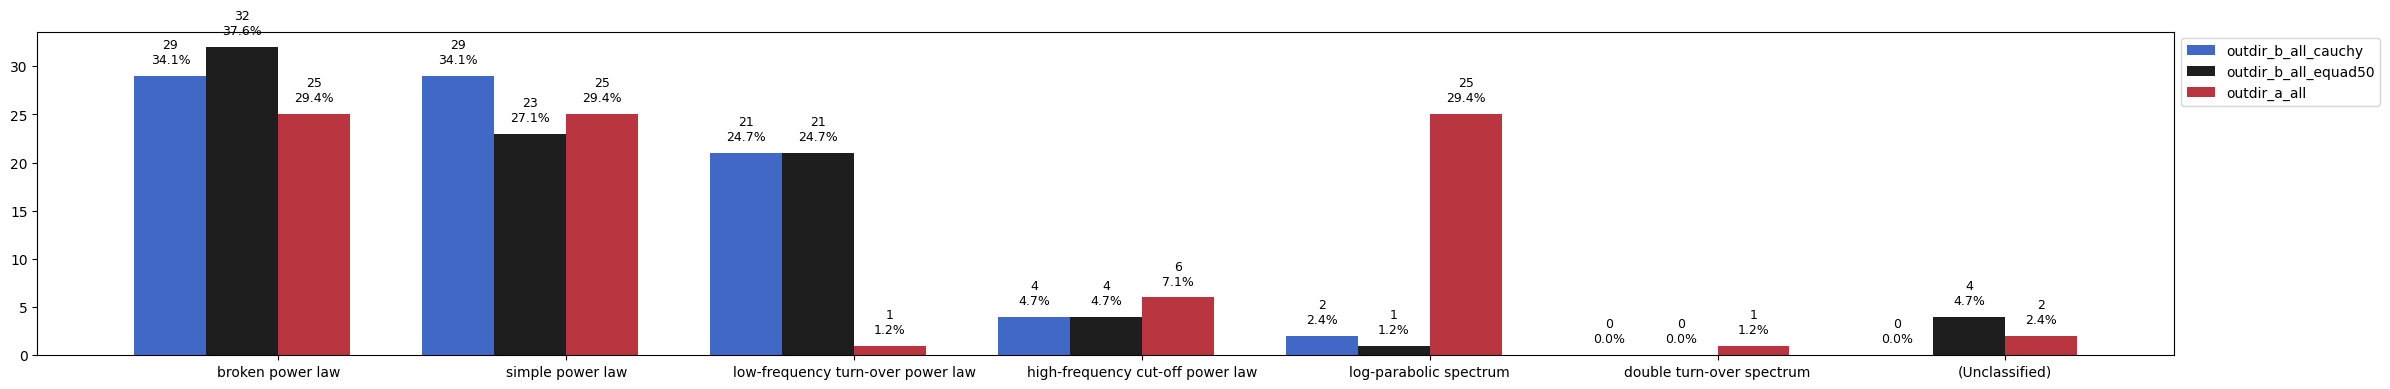

In [7]:
bar_chart(outdirs_1, 'bar_chart_3.png', msp=True)

outdir_b_all_cauchy:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882
outdir_b_all_equad50:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 868
outdir_a_all:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882


,Model,outdir_b_all_cauchy,outdir_b_all_equad50,outdir_a_all
0,broken power law,272 / 769 (35.4%),222 / 769 (28.9%),289 / 769 (37.6%)
1,simple power law,203 / 769 (26.4%),256 / 769 (33.3%),146 / 769 (19.0%)
2,low-frequency turn-over power law,187 / 769 (24.3%),186 / 769 (24.2%),60 / 769 (7.8%)
3,double turn-over spectrum,55 / 769 (7.2%),34 / 769 (4.4%),28 / 769 (3.6%)
4,high-frequency cut-off power law,26 / 769 (3.4%),22 / 769 (2.9%),81 / 769 (10.5%)
5,log-parabolic spectrum,25 / 769 (3.3%),27 / 769 (3.5%),157 / 769 (20.4%)
6,(Unclassified),1 / 769 (0.1%),22 / 769 (2.9%),8 / 769 (1.0%)


,outdir_b_all_cauchy,outdir_b_all_equad50
broken_power_law,293 / 768 (38.2%),202 / 747 (27.0%)
double_turn_over_spectrum,209 / 768 (27.2%),141 / 747 (18.9%)
high_frequency_cut_off_power_law,140 / 768 (18.2%),84 / 747 (11.2%)
log_parabolic_spectrum,211 / 768 (27.5%),162 / 747 (21.7%)
low_frequency_turn_over_power_law,259 / 768 (33.7%),199 / 747 (26.6%)
(Any ln BF > 3),326 / 768 (42.4%),231 / 747 (30.9%)
(All ln BF < -3),0 / 768 (0.0%),0 / 747 (0.0%)


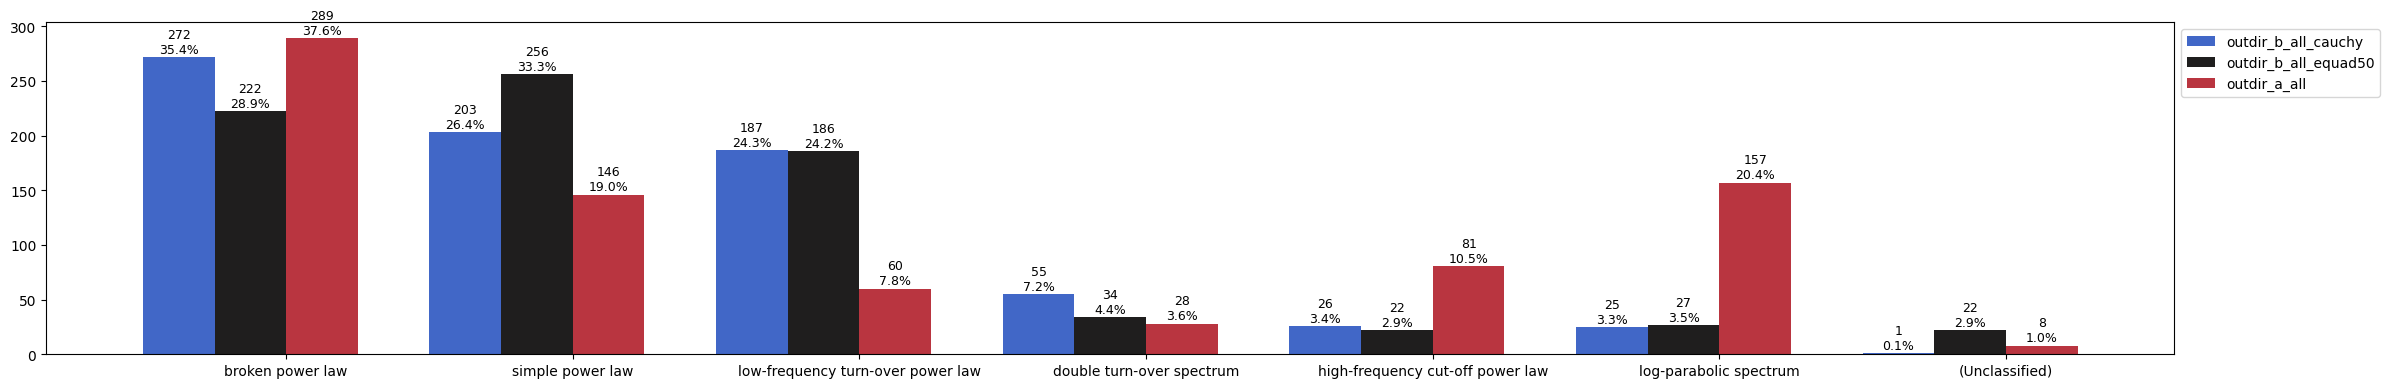

In [8]:
bar_chart(outdirs_1, 'bar_chart_4.png', ten_points=True)